In [1]:
%matplotlib inline

import cv2
from exif import Image
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle

from frameworks.opencv.homography.homography_matrix import UnmatchedKeypoints_PointFinder, UnmatchedDescriptors_Descriptor, RANSAC_MatrixEstimator, BatchHomographyMatrixEstimator
from frameworks.opencv.homography.stiching import make_stiching, color_matrix_applier, color_blender
from frameworks.pytorch.datasets.images_group_dataset import ImagesGroupDataset
from platges_utils.datasets.platgesbcn_segmentation_dataset import PlatgesBCNSegmentationDataset
from platges_utils.map_model import MapModel, gps_search_map_model, context_map_model


plt.rcParams['figure.figsize'] = [25, 15]
np.set_printoptions(formatter={'float' : lambda x: f"{x:10.3f}"})


In [2]:

#dataset = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_all.csv')
dataset = ImagesGroupDataset(json_path='./data_lists/platges2022_concept.json', data_root='', downsample=None, read_flag=cv2.IMREAD_COLOR)

#print(list(dataset[0])[0][1]) # path (1) from the first image (0) of the first group (dataset[0]) unzipped

for d in list(dataset[0]):
    print(d[1])


/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0623.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0624.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0625.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0626.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0627.JPG


In [4]:

NUM_IMGS_SUBSET = 2
OFFSET_SUBSET = 0

NUM_IMGS_PLOT_POINTS = 2
OFFSET_PLOT_POINTS = 0



---

# Manual correspondances


In [5]:
# TODO: csv with img_idx_1, left_or_right_img_idx_1, x1, y1, img_idx_2, left_or_right_img_idx_2, x2, y2

handpicked_kps = [
    cv2.KeyPoint_convert([[3263, 1000], [2088, 974], [491, 943], [279, 973], [1751, 978], [1683, 952], [175, 939], [1374, 1029], [1582, 944], [2894, 1016], [2961, 946], [3553, 938], [2713, 898], [1701, 952], [70, 999], [236, 937]]),
    
    cv2.KeyPoint_convert([[5241, 976], [3958, 954], [2194, 931], [2050, 962], [3601, 958], [3464, 935], [1848, 928], [3308, 1011], [3341, 929], [4866, 993], [4776, 923], [5410, 911], [4423, 878], [3484, 932], [1896, 989], [1915, 926], 
    [1110, 1028], [2185, 934], [1849, 927], [1247, 1026], [2246, 921], [2134, 919], [2049, 961], [1886, 1025], [1827, 929], [1575, 1012], [1167, 1039], [1559, 939], [422, 901], [434, 904], [352, 935], [31, 975], [583, 894], [204, 950], [240, 932]]),
    
    cv2.KeyPoint_convert([[3529, 991], [4369, 898], [3984, 895], [3667, 993], [4404, 884], [4281, 885], [4321, 925], [4341, 986], [3962, 894], [3985, 976], [3616, 1005], [3717, 907], [2370, 883], [2386, 886], [2421, 914], [2211, 953], [2517, 873], [2300, 929], [2278, 912],
    [3233, 873], [3309, 873], [2885, 838], [2513, 873], [2386, 886], [2371, 884], [2278, 912], [2413, 919], [2301, 928], [2213, 956], [2284, 869], [1363, 865], [635, 988], [705, 952], [760, 894], [834, 892], [972, 887], [2433, 870], [2319, 927], [2330, 894], [2356, 871], [639, 866]]),
    
    cv2.KeyPoint_convert([[5154, 818], [5240, 817], [4667, 788], [4362, 823], [4250, 837], [4235, 837], [4224, 861], [4391, 867], [4304, 875], [4292, 903],[4115, 821], [3163, 823], [2744, 944], [2705, 900], [2564, 855], [2634, 854], [2770, 850], [4274, 819], [4319, 875], [4218, 843], [4194, 822], [2361, 830],
    [1171, 931], [1693, 886], [1629, 1003], [2120, 977], [2735, 944], [2347, 834], [1747, 836], [220, 1054], [180, 979], [2704, 899], [102, 1106]]),
    
    cv2.KeyPoint_convert([[3512, 886], [3909, 845], [4272, 951], [4716, 924], [5248, 890], [4399, 793], [3833, 795], [2985, 1001], [2961, 928], [5063, 851], [3048, 1048]])
]
id_keypoints_dict = {i : kps for i, kps in enumerate(handpicked_kps)}

handpicked_descriptors = [
    [(0, 0)] * 16,
    [(1, 1)] * 16 + [(1, 0)] * 19,
    [(2, 1)] * 19 + [(2, 0)] * 22,
    [(3, 1)] * 22 + [(3, 0)] * 11,
    [(4, 1)] * 11
]
id_descriptors_dict = {i : des for i, des in enumerate(handpicked_descriptors)}


DISTANCE = 10 # 10
def point_matcher(des1, des2):
    # desX have vectors of tuples: current_image_idx (smaller on the right size, higher on the lft size) and 0/1 (to the left correspondance == 0 and to the right correspondance == 1)
    left, right, order = (des1, des2, 1) if des1[0][0] > des2[0][0] else (des2, des1, 0)
    
    idx_left_to_right = np.argwhere(np.asarray(left)[:, 1] == 1).flatten().tolist()
    idx_right_to_left = np.argwhere(np.asarray(right)[:, 1] == 0).flatten().tolist()
    
    # return [cv2.DMatch(i, j, DISTANCE) if order else cv2.DMatch(j, i, DISTANCE) for i, j in zip(idx_left_to_right, idx_right_to_left)]
    if order:
        return [cv2.DMatch(i, j, DISTANCE) for i, j in zip(idx_left_to_right, idx_right_to_left)]
    else:
        return [cv2.DMatch(i, j, DISTANCE) for i, j in zip(idx_right_to_left, idx_left_to_right)]


[(3263.0, 1000.0), (2088.0, 974.0), (491.0, 943.0), (279.0, 973.0), (1751.0, 978.0), (1683.0, 952.0), (175.0, 939.0), (1374.0, 1029.0), (1582.0, 944.0), (2894.0, 1016.0), (2961.0, 946.0), (3553.0, 938.0), (2713.0, 898.0), (1701.0, 952.0), (70.0, 999.0), (236.0, 937.0)]


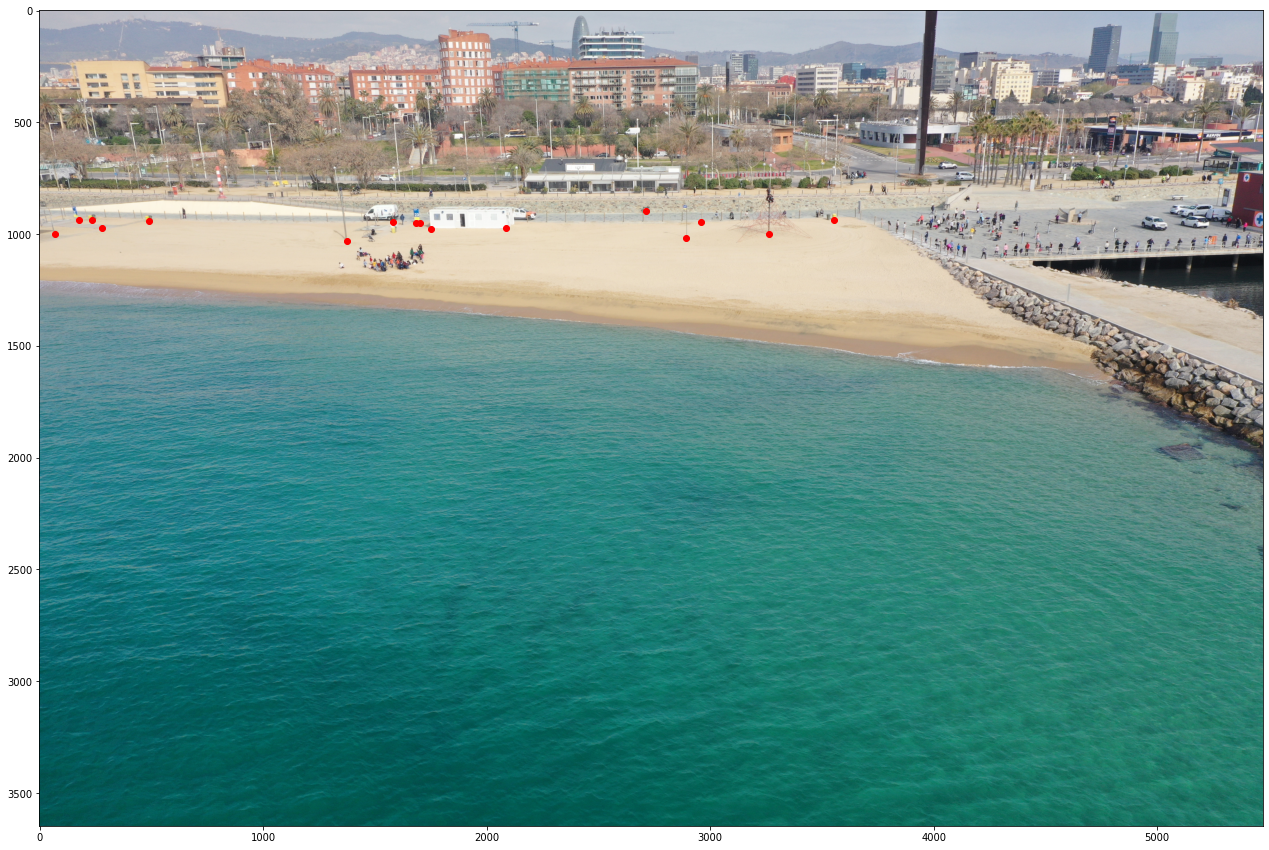

[(5241.0, 976.0), (3958.0, 954.0), (2194.0, 931.0), (2050.0, 962.0), (3601.0, 958.0), (3464.0, 935.0), (1848.0, 928.0), (3308.0, 1011.0), (3341.0, 929.0), (4866.0, 993.0), (4776.0, 923.0), (5410.0, 911.0), (4423.0, 878.0), (3484.0, 932.0), (1896.0, 989.0), (1915.0, 926.0), (1110.0, 1028.0), (2185.0, 934.0), (1849.0, 927.0), (1247.0, 1026.0), (2246.0, 921.0), (2134.0, 919.0), (2049.0, 961.0), (1886.0, 1025.0), (1827.0, 929.0), (1575.0, 1012.0), (1167.0, 1039.0), (1559.0, 939.0), (422.0, 901.0), (434.0, 904.0), (352.0, 935.0), (31.0, 975.0), (583.0, 894.0), (204.0, 950.0), (240.0, 932.0)]


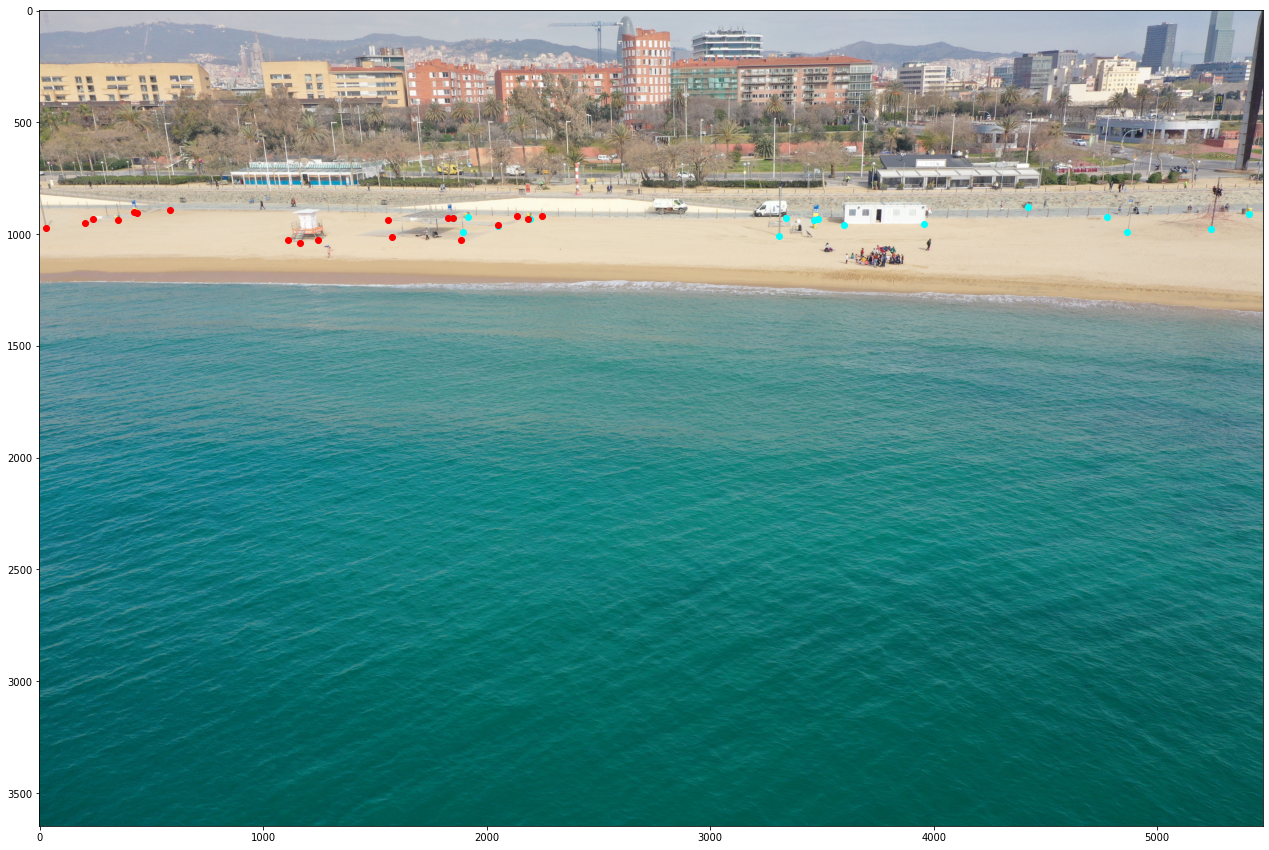

In [6]:

NUM_IMGS = min(NUM_IMGS_PLOT_POINTS, len(handpicked_kps))
OFFSET = OFFSET_PLOT_POINTS % (len(handpicked_kps) - NUM_IMGS + 1)

for i, (d, kps, des) in enumerate(zip(list(dataset[0]), handpicked_kps, handpicked_descriptors)):
    if i < OFFSET : continue
    if i >= OFFSET + NUM_IMGS : break
    
    img = d[0]
    
    try:
        kps_x_red, kps_y_red = list(zip(*[(kp.pt[0], kp.pt[1]) for kp, de in zip(kps, des) if de[1] == 0]))
    except:
        kps_x_red, kps_y_red = [], []
    try:
        kps_x_cyan, kps_y_cyan = list(zip(*[(kp.pt[0], kp.pt[1]) for kp, de in zip(kps, des) if de[1] == 1]))
    except:
        kps_x_cyan, kps_y_cyan = [], []
    
    print([kp.pt for kp in kps])
    
    plt.imshow(img.astype(np.uint8)) #, cmap=plt.cm.gray)
    plt.plot(kps_x_cyan, kps_y_cyan, color='cyan', marker='o', linestyle='None', markersize=6)
    plt.plot(kps_x_red, kps_y_red, color='red', marker='o', linestyle='None', markersize=6)

    plt.show()


---

In [7]:

ann_path = '/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/masks/'

v_img = []
v_masks = []
v_homographies = []
v_gps = []

for d in list(dataset[0]):
    
    v_img.append(d[0])
    
    with open(d[1], 'rb') as src:
        img = Image(src)
        gps_to_sec = lambda gps : 3600 * gps[0] + 60 * gps[1] + gps[0]
        v_gps.append((gps_to_sec(img.gps_longitude), gps_to_sec(img.gps_latitude)))
        
    with open(f'{ann_path}/{os.path.basename(d[1])[:-4]}.segments.pkl', 'rb') as f:
        mask = pickle.load(f, encoding='latin1')
        if True:
            mask[mask == 1] = 4
            mask[mask == 2] = 1
            mask[mask == 4] = 2
        v_masks.append(mask)
    
    #v_homographies.append(np.eye(3))



---

# RanSaC with all images


In [7]:

id_list = list(range(len(handpicked_kps)))
point_finder = UnmatchedKeypoints_PointFinder(lambda x : id_list.pop(0), id_keypoints_dict)

id_list2 = list(range(len(handpicked_descriptors)))
descriptor_finder = UnmatchedDescriptors_Descriptor(lambda x : id_list2.pop(0), id_descriptors_dict)

matrix_finder = RANSAC_MatrixEstimator(point_matcher=point_matcher, min_match_count=4, ransacReprojThreshold=116.1, maxIters=None)

homographies_estimator = BatchHomographyMatrixEstimator(point_finder=point_finder, descriptor_finder=descriptor_finder, matrix_finder=matrix_finder)
v_homographies, matches, inliers_mask, n_matches = homographies_estimator(v_img)


In [ ]:

stiched = make_stiching(v_img, v_homographies, matrix_applier=color_matrix_applier, blender=color_blender)
stiched = stiched.astype(int)

plt.imshow(stiched)
plt.show()


# RanSaC with subset

In [13]:

NUM_IMGS = min(NUM_IMGS_SUBSET, len(v_img))
OFFSET = OFFSET_SUBSET % (len(v_img) - NUM_IMGS + 1)

id_list = list(range(len(handpicked_kps)))[OFFSET:OFFSET+NUM_IMGS]
point_finder = UnmatchedKeypoints_PointFinder(lambda x : id_list.pop(0), id_keypoints_dict)

id_list2 = list(range(len(handpicked_descriptors)))[OFFSET:OFFSET+NUM_IMGS]
descriptor_finder = UnmatchedDescriptors_Descriptor(lambda x : id_list2.pop(0), id_descriptors_dict)

matrix_finder = RANSAC_MatrixEstimator(point_matcher=point_matcher, min_match_count=4, ransacReprojThreshold=116.1, maxIters=None)


homographies_estimator = BatchHomographyMatrixEstimator(point_finder=point_finder, descriptor_finder=descriptor_finder, matrix_finder=matrix_finder)
v_homographies, matches, inliers_mask, n_matches = homographies_estimator(v_img[OFFSET:OFFSET+NUM_IMGS])


In [14]:
v_homographies

[matrix([[     1.000,      0.000,   5584.000],
         [     0.000,      1.000,    121.000],
         [     0.000,      0.000,      1.000]]),
 matrix([[     1.053,     -1.586,   5783.467],
         [     0.007,      1.228,      0.145],
         [     0.000,      0.000,      0.990]])]

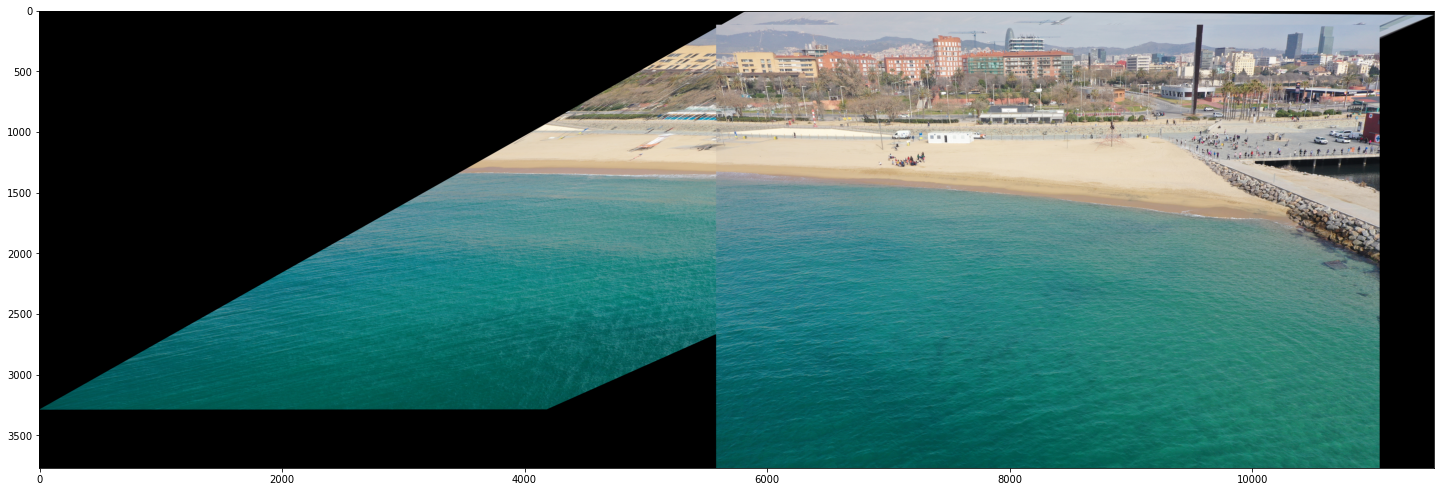

In [15]:

stiched = make_stiching(v_img[OFFSET:OFFSET+NUM_IMGS], v_homographies, matrix_applier=color_matrix_applier, blender=color_blender)
stiched = stiched.astype(int)

plt.imshow(stiched)
plt.show()



---

# LMS with all images
Assuming manual correspondances have no outliers


In [8]:

id_list_aux = list(range(len(handpicked_kps)))
point_finder_aux = UnmatchedKeypoints_PointFinder(lambda x : id_list_aux.pop(0), id_keypoints_dict)

id_list2_aux = list(range(len(handpicked_descriptors)))
descriptor_finder_aux = UnmatchedDescriptors_Descriptor(lambda x : id_list2_aux.pop(0), id_descriptors_dict)

def matrix_finder_aux(kp1, des1, kp2, des2):
    matches = point_matcher(des1, des2)
    
    src_pts12 = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
    dst_pts12 = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)
    
    H, mask = cv2.findHomography(src_pts12, dst_pts12)
    return H, matches, mask


homographies_estimator_aux = BatchHomographyMatrixEstimator(point_finder=point_finder_aux, descriptor_finder=descriptor_finder_aux, matrix_finder=matrix_finder_aux, max_width=MAX_WIDTH, max_height=MAX_HEIGHT)
v_homographies_aux, _, _, _ = homographies_estimator_aux(v_img)


In [9]:

idx = 1
idx = idx % len(v_homographies)
print(v_homographies[idx], end='\n---\n')
print(v_homographies_aux[idx])


[[     1.171      3.333  53515.981]
 [     0.008      1.257    276.364]
 [     0.000      0.000      0.990]]
---
[[     1.098      0.310  24180.281]
 [     0.008      1.254    255.573]
 [     0.000      0.000      0.990]]


In [ ]:

stiched = make_stiching(v_img, v_homographies_aux, matrix_applier=color_matrix_applier, blender=color_blender)
stiched = stiched.astype(int)

plt.imshow(stiched)
plt.show()


# LMS with subset

In [18]:

NUM_IMGS = min(NUM_IMGS_SUBSET, len(v_img))
OFFSET = OFFSET_SUBSET % (len(v_img) - NUM_IMGS + 1)

id_list_aux = list(range(len(handpicked_kps)))[OFFSET:OFFSET+NUM_IMGS]
point_finder_aux = UnmatchedKeypoints_PointFinder(lambda x : id_list_aux.pop(0), id_keypoints_dict)

id_list2_aux = list(range(len(handpicked_descriptors)))[OFFSET:OFFSET+NUM_IMGS]
descriptor_finder_aux = UnmatchedDescriptors_Descriptor(lambda x : id_list2_aux.pop(0), id_descriptors_dict)

def matrix_finder_aux(kp1, des1, kp2, des2):
    matches = point_matcher(des1, des2)
    
    src_pts12 = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
    dst_pts12 = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)
    
    H, mask = cv2.findHomography(src_pts12, dst_pts12)
    return H, matches, mask

homographies_estimator_aux = BatchHomographyMatrixEstimator(point_finder=point_finder_aux, descriptor_finder=descriptor_finder_aux, matrix_finder=matrix_finder_aux)
v_homographies_aux, _, _, _ = homographies_estimator_aux(v_img[OFFSET:OFFSET+NUM_IMGS])


In [19]:

idx = 1
idx = idx % len(v_homographies)
print(v_homographies[idx], end='\n---\n')
print(v_homographies_aux[idx])


[[     1.053     -1.586   5783.467]
 [     0.007      1.228      0.145]
 [     0.000      0.000      0.990]]
---
[[     1.053     -1.586   5783.467]
 [     0.007      1.228      0.145]
 [     0.000      0.000      0.990]]


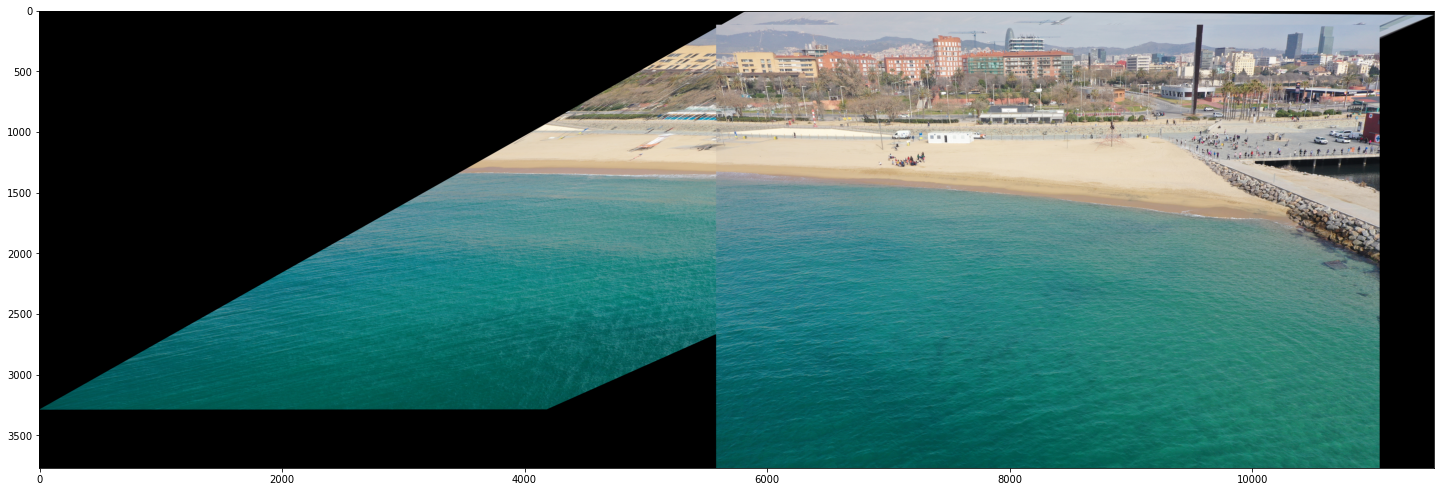

In [20]:

stiched = make_stiching(v_img[OFFSET:OFFSET+NUM_IMGS], v_homographies_aux, matrix_applier=color_matrix_applier, blender=color_blender)
stiched = stiched.astype(int)

plt.imshow(stiched)
plt.show()


---

In [21]:

if True:
    id_list = list(range(len(handpicked_kps)))
    point_finder = UnmatchedKeypoints_PointFinder(lambda x : id_list.pop(0), id_keypoints_dict)

    id_list2 = list(range(len(handpicked_descriptors)))
    descriptor_finder = UnmatchedDescriptors_Descriptor(lambda x : id_list2.pop(0), id_descriptors_dict)

    matrix_finder = RANSAC_MatrixEstimator(point_matcher=point_matcher, min_match_count=4, ransacReprojThreshold=116.1, maxIters=None)

    homographies_estimator = BatchHomographyMatrixEstimator(point_finder=point_finder, descriptor_finder=descriptor_finder, matrix_finder=matrix_finder)
    v_homographies, matches, inliers_mask, n_matches = homographies_estimator(v_img)

else:
    id_list_aux = list(range(len(handpicked_kps)))
    point_finder_aux = UnmatchedKeypoints_PointFinder(lambda x : id_list_aux.pop(0), id_keypoints_dict)

    id_list2_aux = list(range(len(handpicked_descriptors)))
    descriptor_finder_aux = UnmatchedDescriptors_Descriptor(lambda x : id_list2_aux.pop(0), id_descriptors_dict)

    def matrix_finder_aux(kp1, des1, kp2, des2):
        matches = point_matcher(des1, des2)

        src_pts12 = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
        dst_pts12 = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts12, dst_pts12)
        return H, matches, mask


    homographies_estimator_aux = BatchHomographyMatrixEstimator(point_finder=point_finder_aux, descriptor_finder=descriptor_finder_aux, matrix_finder=matrix_finder_aux, max_width=MAX_WIDTH, max_height=MAX_HEIGHT)
    v_homographies, _, _, _ = homographies_estimator_aux(v_img)

In [22]:

name = 'concepte'
map_model = MapModel(v_img, v_masks, v_homographies, v_gps, name)
print(map_model[0][3])
map_model.save_map_model(root='./model_parameters/mapes_platges/')


(7922.0, 149021.0)


In [23]:

np.set_printoptions(formatter={'float': lambda x: f"{x:0.2f}"})

if False:
    print('---')
    for homographies in v_homographies:
        print(homographies, end='\n---\n')

if False:
    IMG1 = 2 % (len(v_img) - 1)
    IMG2 = IMG1 + 1
    output = cv2.drawMatches(v_img[0], handpicked_kps[0], v_img[1], handpicked_kps[1], matches[0, 1], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(output)
    plt.show()
elif False:
    IMG = 2
    pts = cv2.KeyPoint_convert(handpicked_kps[IMG])
    plt.imshow(v_img[IMG])
    plt.plot(pts[:, 0], pts[:, 1], color='cyan', marker='o', linestyle='None', markersize=10)
    plt.show()



<br>

<span style="font-size:1.25em;">
El dron te un pla de vol on les posicions de cara imatge són similars.
</span>

gps_search_map_model() aplica el criteri de menor distancia eunclidea per localitzar la platja entre els models.


In [24]:
current_filename = gps_search_map_model((7972.0, 149001.0), ['./model_parameters/mapes_platges/concepte.hdf5'])
print(current_filename)

with context_map_model(current_filename) as current_model:
    print(current_model.get_name())
    print(current_model.get_elements()[3].shape)
    

./model_parameters/mapes_platges/concepte.hdf5
concepte
(5, 2)
